# import relevant libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import sklearn
import pickle
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedKFold,cross_val_score,learning_curve

# load the datset

In [2]:
data = pd.read_csv('spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# drop unwanted columns

In [3]:
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v2" : "text", "v1":"label"})
data.sample(5)

,label,text
1027,ham,Are you not around or just still asleep? :V
422,ham,Siva is in hostel aha:-.
4021,ham,U gd lor go shopping i got stuff to do. U wan ...
4133,ham,Is it your yahoo boys that bring in the perf? ...
4640,ham,Havent.


In [4]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

# preprocessing and exploring dataset

In [5]:
nltk.download("punkt")
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# build wordcloud to detect common words in spam and not spam messages

In [6]:
ham_words = ''
spam_words = ''

In [7]:
# Creating a corpus of spam messages
for val in data[data['label'] == 'spam'].text:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '

# Creating a corpus of ham messages
for val in data[data['label'] == 'ham'].text:
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '

In [8]:
spam_wordcloud = WordCloud(width=500, height=300).generate(spam_words)
ham_wordcloud = WordCloud(width=500, height=300).generate(ham_words)

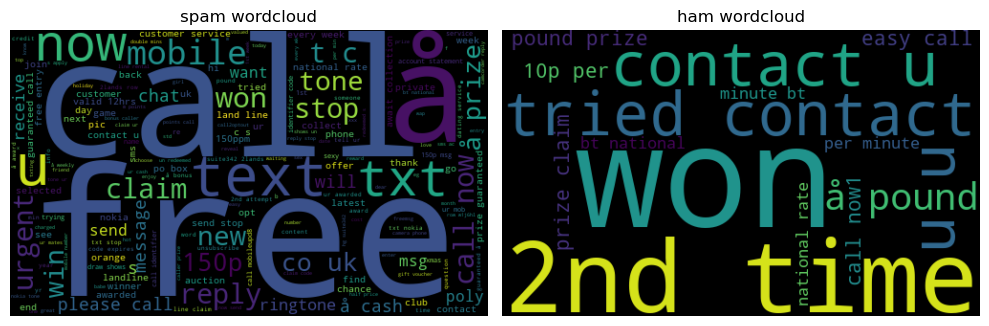

In [9]:
#Spam Word cloud
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.title('spam wordcloud')
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis("off")
#Creating Ham wordcloud
plt.subplot(1,2,2)
plt.title('ham wordcloud')
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.show()

In [10]:
data = data.replace(['ham','spam'],[0, 1])
data.sample(5)

,label,text
3566,1,Collect your VALENTINE'S weekend to PARIS inc ...
577,0,ÌÏ wait 4 me in sch i finish ard 5..
258,1,We tried to contact you re your reply to our o...
5354,0,Aiyo cos i sms Ì_ then Ì_ neva reply so i wait...
4761,0,Me too! Have a lovely night xxx


# using nltk remove punctuation and stopword from messages

In [11]:
nltk.download('stopwords')
#remove the punctuations and stopwords
import string
def text_process(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    return " ".join(text)

data['text'] = data['text'].apply(text_process)
data.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,text
0,0,Go jurong point crazy Available bugis n great ...
1,0,Ok lar Joking wif u oni
2,1,Free entry 2 wkly comp win FA Cup final tkts 2...
3,0,U dun say early hor U c already say
4,0,Nah dont think goes usf lives around though


In [12]:
text = pd.DataFrame(data['text'])
label = pd.DataFrame(data['label'])

# converting words to vectors using count vectorizer

In [13]:
from collections import Counter
total_counts = Counter()
for i in range(len(text)):
    for word in text.values[i][0].split(" "):
        total_counts[word] += 1

print("Total words in dataset: ", len(total_counts))

Total words in dataset:  11305


In [14]:
# Sorting in decreasing order (Word with highest frequency appears first)
vocab = sorted(total_counts, key=total_counts.get, reverse=True)
print(vocab[:50])

['u', '2', 'call', 'U', 'get', 'Im', 'ur', '4', 'ltgt', 'know', 'go', 'like', 'dont', 'come', 'got', 'time', 'day', 'want', 'Ill', 'lor', 'Call', 'home', 'send', 'going', 'one', 'need', 'Ok', 'good', 'love', 'back', 'n', 'still', 'text', 'im', 'later', 'see', 'da', 'ok', 'think', 'Ì', 'free', 'FREE', 'r', 'today', 'Sorry', 'week', 'phone', 'mobile', 'cant', 'tell']


In [15]:
# Mapping from words to index
vocab_size = len(vocab)
word2idx = {}
#print vocab_size
for i, word in enumerate(vocab):
    word2idx[word] = i
# Text to Vector
def text_to_vector(text):
    word_vector = np.zeros(vocab_size)
    for word in text.split(" "):
        if word2idx.get(word) is None:
            continue
        else:
            word_vector[word2idx.get(word)] += 1
    return np.array(word_vector)
# Convert all titles to vectors
word_vectors = np.zeros((len(text), len(vocab)), dtype=np.int_)
for i, (_, text_) in enumerate(text.iterrows()):
    word_vectors[i] = text_to_vector(text_[0])
word_vectors.shape

(5572, 11305)

# converting words to vectors using TF-IDF Vectorizer

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['text'])
vectors.shape

(5572, 9376)

In [17]:
features = vectors

# split into train and test data set

In [18]:
X_train, X_test, y_train, y_test = train_test_split(features, data['label'], test_size=0.15, random_state=111)

# classify using sklearn's pre built classifiers

In [19]:
#import sklearn packages for building classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [20]:
#initialize multiple classification models
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)

In [21]:
#create a dictionary of variables and models
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}

In [22]:
def train(clf, features, targets):
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

pred_score = []
for i,j in clfs.items():
    train(j, X_train, y_train)
    pred = predict(j, X_test)
    pred_score.append((i, [accuracy_score(y_test , pred)]))
pred_score

[('SVC', [0.9784688995215312]),
 ('KN', [0.9330143540669856]),
 ('NB', [0.9880382775119617]),
 ('DT', [0.9605263157894737]),
 ('LR', [0.9533492822966507]),
 ('RF', [0.9796650717703349])]

# model predictions

In [31]:
def detect(x):
    if x == 1:
        print ("Message is SPAM")
    else:
        print ("Message is NOT Spam")

In [34]:
testsms = ["Free gift"]
integers = vectorizer.transform(testsms)

In [35]:
x = mnb.predict(integers)
detect(x)

Message is SPAM


# checking classification result with confusion matrix

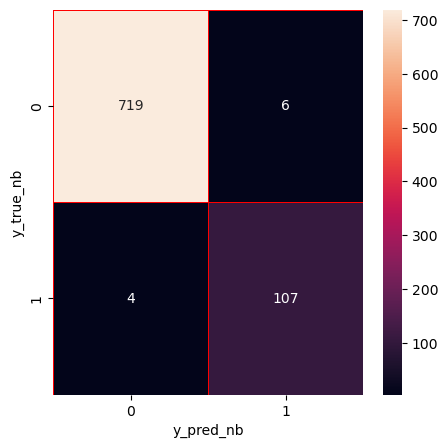

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Naive Bayes
y_pred_nb = mnb.predict(X_test)
y_true_nb = y_test
cm = confusion_matrix(y_true_nb, y_pred_nb)
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred_nb")
plt.ylabel("y_true_nb")
plt.show()